Script desgined for the baseline comparisons of the complete dataset. 

In [ ]:
# import libraries and load data.
import pandas as pd
import numpy as np 
from scipy.stats import norm, shapiro
from sklearn.preprocessing import StandardScaler
from utils_dir.graph_crqa_utils import *
import statsmodels.formula.api as smf
from lmm_utils import *


merged_all = pd.read_csv(f"merged_crqa_iaaft.csv").copy()

merged_all

,window_index,head_ed_vel_REC,head_ed_vel_DET,head_ed_vel_MAXLINE,head_ed_vel_ENTROPY,head_ed_vel_MEANLINE,head_ed_vel_LAM,head_ed_vel_DIV,head_ed_vel_MAXL_POSS,head_ed_vel_err_code,...,body_ed_vel_MAXLINE,body_ed_vel_ENTROPY,body_ed_vel_MEANLINE,body_ed_vel_LAM,body_ed_vel_DIV,body_ed_vel_MAXL_POSS,body_ed_vel_err_code,couple,trial,pair
0,0,11.074285,69.383228,51.2,2.017458,3.222033,0.817080,0.021477,1484.0,0.0,...,31.3,1.493407,2.638069,0.640078,0.032762,1484.0,0.0,83,trial0,pseudo
1,1,7.889982,55.193697,29.0,1.662452,2.784852,0.688032,0.035178,1484.0,0.0,...,11.9,0.767650,2.204053,0.259444,0.091641,1484.0,0.0,83,trial0,pseudo
2,2,9.048775,64.951462,45.7,1.934154,3.125690,0.797099,0.023024,1484.0,0.0,...,20.9,1.108007,2.365831,0.453645,0.048595,1484.0,0.0,83,trial0,pseudo
3,3,7.665412,61.888336,35.2,1.817571,2.944629,0.793558,0.029127,1484.0,0.0,...,14.3,0.902918,2.261657,0.447369,0.071711,1484.0,0.0,83,trial0,pseudo
4,4,5.782271,54.393048,28.8,1.569612,2.691159,0.745321,0.035992,1484.0,0.0,...,12.3,0.791917,2.214230,0.320612,0.086815,1484.0,0.0,83,trial0,pseudo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8365,4,4.366749,24.227646,22.0,0.941552,2.275960,0.388574,0.045455,1484.0,0.0,...,3.0,0.105591,2.013889,0.123164,0.333333,1484.0,0.0,181,trial0,actual
8366,5,3.400922,20.618983,12.0,0.842994,2.229070,0.364981,0.083333,1484.0,0.0,...,3.0,0.162580,2.023857,0.152112,0.333333,1484.0,0.0,181,trial0,actual
8367,6,3.280409,21.772352,17.0,0.850338,2.234233,0.338109,0.058824,1484.0,0.0,...,3.0,0.194769,2.030075,0.144215,0.333333,1484.0,0.0,181,trial0,actual
8368,7,5.411678,30.080803,24.0,1.019666,2.316340,0.400759,0.041667,1484.0,0.0,...,3.0,0.207022,2.032550,0.166199,0.333333,1484.0,0.0,181,trial0,actual


In [5]:
"""
Get averaged DV outcome collapsed across window_index.

Behavioural Signals: headRel_ed_vel & body_ed_vel
CRQA outcomes: REC, DET, MAXLINE, LAM, ENTROPY
"""


dv = 'headRel_ed_vel_ENTROPY' # Define the DV.

# Collapse across window_index for each trial and couple
collapsed = merged_all.groupby(['couple', 'trial', 'pair'])[dv].mean().reset_index()

# Now get mean, sd, min, and max DV for each group per trial (averaging across couples)
trial_summary = (
    collapsed
    .groupby(['trial', 'pair'])[dv]
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .reset_index()
)

print(trial_summary)

    trial    pair      mean       std       min       max  count
0  trial0  actual  0.941084  0.268859  0.247842  1.647509    112
1  trial0  pseudo  0.878446  0.215628  0.401104  1.421209    112
2  trial1  actual  0.846401  0.252934  0.278337  1.515756    142
3  trial1  pseudo  0.800550  0.200330  0.204035  1.388211    142
4  trial2  actual  0.824650  0.271511  0.119085  1.546655    141
5  trial2  pseudo  0.769039  0.225440  0.050614  1.362015    141


In [6]:
"""
Identify outliers in collapsed data 5 standard deviations from the mean.
"""
collapsed = merged_all.groupby(['couple', 'trial', 'pair']).mean().reset_index()

# Number of standard deviations from the mean to use as the outlier threshold
num_std = 5

# Identify numerical columns (DVs), excluding 'id' and 'condition'
DVs = collapsed.select_dtypes(include=['number']).columns.difference(['couple'])

outlier_records = [] # empty array to record of outliers


# Loop through each dv and calculate outliers. 
for var in DVs:
    mean = collapsed[var].mean()
    std = collapsed[var].std()
    lower_bound = mean - num_std * std
    upper_bound = mean + num_std * std

    # Filter outliers
    outliers = collapsed[(collapsed[var] < lower_bound) | (collapsed[var] > upper_bound)][['couple', 'trial', 'pair',var]]
    # Store results
    if not outliers.empty:
        for index, row in outliers.iterrows():
            outlier_records.append({
                'couple': row['couple'],
                'trial': row['trial'],
                'pair': row['pair'],
                'measure': var,
                'value': row[var]

            })



# Combine results into a single DataFrame
if outlier_records:
    title = None
    for record in outlier_records:
        m = record['measure']
        if not title == m:
            
            title = m
            print(f"\n{title}:")
        
        
        print(f" * Couple {record['couple']}: ({record['trial']}||{record['pair']}): {round(record['value'], 3)}")
        
else:
    print("No outliers detected.")





body_ed_vel_MAXLINE:
 * Couple 37: (trial1||actual): 82.0
 * Couple 37: (trial1||pseudo): 48.146
 * Couple 102: (trial1||actual): 47.1
 * Couple 136: (trial0||actual): 44.667

body_ed_vel_MEANLINE:
 * Couple 37: (trial1||actual): 8.62
 * Couple 37: (trial2||actual): 4.197

body_ed_vel_REC:
 * Couple 37: (trial1||actual): 20.259
 * Couple 37: (trial1||pseudo): 18.257

headRel_ed_vel_DIV:
 * Couple 34: (trial2||pseudo): 0.378

headRel_ed_vel_MAXLINE:
 * Couple 37: (trial1||actual): 48.0

headRel_ed_vel_MEANLINE:
 * Couple 37: (trial1||actual): 3.577
 * Couple 37: (trial1||pseudo): 3.053

headRel_ed_vel_REC:
 * Couple 37: (trial1||actual): 12.329
 * Couple 37: (trial1||pseudo): 11.98

head_ed_vel_DIV:
 * Couple 34: (trial2||actual): 0.233
 * Couple 34: (trial2||pseudo): 0.218
 * Couple 131: (trial1||pseudo): 0.23
 * Couple 170: (trial1||actual): 0.214

head_ed_vel_MAXLINE:
 * Couple 84: (trial2||actual): 84.0

head_ed_vel_MEANLINE:
 * Couple 84: (trial2||actual): 4.59


In [ ]:
merged_all = merged_all[merged_all['couple'] != 37] # More than 5 std > mean and did not complete trial0

In [8]:
from numpy.polynomial.legendre import legvander

# CHOSE DATA TO ANALYSE
df = merged_all.copy()

# Scale window index to range from -1 to 1
df['window_scaled'] = 2 * (df['window_index'] - df['window_index'].min()) / (df['window_index'].max() - df['window_index'].min()) - 1

df['window_scaled_c'] = df['window_scaled'] - df['window_scaled'].mean()

# CREATE  2nd-order orthogonal polynomials
X = legvander(df['window_scaled'], deg=2)

# add to dataframe
df['ot1'] = X[:, 1]  # linear orthogonal component
df['ot2'] = X[:, 2]  # quadratic orthogonal component


In [9]:
dv_cols = [col for col in df.columns if col.endswith(tuple(['REC', 'DET', 'MAXLINE', 'ENTROPY', 'LAM']))]

# Collapse data across windows
df_summary = df.groupby(['couple', 'trial', 'pair'])[dv_cols].mean().reset_index()


print(df_summary.columns)

Index(['couple', 'trial', 'pair', 'head_ed_vel_REC', 'head_ed_vel_DET',
       'head_ed_vel_MAXLINE', 'head_ed_vel_ENTROPY', 'head_ed_vel_LAM',
       'headRel_ed_vel_REC', 'headRel_ed_vel_DET', 'headRel_ed_vel_MAXLINE',
       'headRel_ed_vel_ENTROPY', 'headRel_ed_vel_LAM', 'body_ed_vel_REC',
       'body_ed_vel_DET', 'body_ed_vel_MAXLINE', 'body_ed_vel_ENTROPY',
       'body_ed_vel_LAM'],
      dtype='object')


In [10]:
# Compute descriptive statistics by DV
dv = 'body_ed_vel_MAXLINE'  # Change this to compute stats for different DVs


# Trial-level stats
trial_stats = df_summary.groupby(['trial', 'pair'])[dv].agg(['mean', 'std', 'min', 'max', 'count'])
trial_stats = trial_stats.rename(columns={'count': 'num_couples'})
print("Trial-level stats:\n", trial_stats)

# Raw trial-level stats 
trial_stats_raw = df.groupby(['trial', 'pair'])[dv].agg(['mean', 'std', 'min','max','count'])
print("Raw trial-level stats:\n", trial_stats_raw)

# Overall stats (across all trials)
overall_stats = df_summary[dv].agg(['mean', 'std', 'min', 'max'])
overall_stats['num_couples'] = df_summary['couple'].nunique()
print("\nOverall stats:\n", overall_stats)

Trial-level stats:
                     mean       std       min        max  num_couples
trial  pair                                                         
trial0 actual  10.610317  6.381760  3.444444  44.666667          112
       pseudo  12.241904  5.896221  4.055556  29.800000          112
trial1 actual   9.859403  5.573791  2.777778  47.100000          141
       pseudo  11.901978  5.630357  3.088889  41.850000          141
trial2 actual   9.066280  4.829280  2.333333  29.461538          140
       pseudo  10.884568  5.604654  3.284615  34.540000          140
Raw trial-level stats:
                     mean       std  min    max  count
trial  pair                                          
trial0 actual  10.329308  9.831504  2.0  148.0    911
       pseudo  11.983864  8.688918  2.3   67.8    911
trial1 actual   9.701733  9.021246  2.0  143.0   1673
       pseudo  11.773640  8.822039  1.9   68.5   1673
trial2 actual   8.833228  7.869540  2.0  107.0   1577
       pseudo  10.629042  

In [11]:
# Ensure categorical encoding
df["trial"] = df["trial"].astype("category")
df["pair"] = df["pair"].astype("category")

df = df_summary.copy()


DVs = [col for col in df.columns if col.endswith('body_ed_vel_ENTROPY')] # Change to suffix of DV of interest (e.g., REC, DET, LAM)

# Store p-values
p_values = {}
effect_sizes = {}
conf_intervals = {}
r2_values = {}

for dv in DVs:
    print(dv)

    formula = f"{dv} ~ C(pair, Treatment(reference='actual')) * C(trial, Treatment(reference='trial0'))"
    try:
        model = smf.mixedlm(
            formula,
            df,
            groups=df["couple"]
        ).fit(reml=False)

        print(f"\nMixed-Effects Model for {dv}:")
        print(model.summary())

        R2_m, R2_c = r2_marginal_conditional(model)
        print(f"Marginal R² (fixed): {R2_m:.3f}")
        print(f"Conditional R² (fixed + random): {R2_c:.3f}")

        r2_values[dv] = {"R2_marginal": R2_m, "R2_conditional": R2_c}


    except Exception as e:
        print(f"Error fitting model for {dv}: {e}")



body_ed_vel_ENTROPY

Mixed-Effects Model for body_ed_vel_ENTROPY:
                                                    Mixed Linear Model Regression Results
Model:                                      MixedLM                          Dependent Variable:                          body_ed_vel_ENTROPY
No. Observations:                           786                              Method:                                      ML                 
No. Groups:                                 141                              Scale:                                       0.0200             
Min. group size:                            4                                Log-Likelihood:                              245.4710           
Max. group size:                            6                                Converged:                                   Yes                
Mean group size:                            5.6                                                                                       

In [ ]:
# Compute marginal means, etc. for model just fitted.
emmeans_df, slopes_df, pairwise_df, slope_contrasts_df = emmeans_with_slopes_rm_1(model, 
                                                                                  factors=["pair", "trial"],
                                                                                  covariates=[],
                                                                                  p_correction="fdr_bh",
                                                                                  comparison_type='pair_only'
                                                                                  )
print(emmeans_df)
print("\n------------------------------------------------------------------------\n")
print(pairwise_df)


     pair   trial   emmeans        se     lower     upper
0  actual  trial1  0.591742  0.015263  0.561781  0.621704
1  actual  trial2  0.554774  0.015291  0.524758  0.584789
2  actual  trial0  0.645049  0.016237  0.613175  0.676922
3  pseudo  trial1  0.571195  0.015290  0.541181  0.601209
4  pseudo  trial2  0.535976  0.015291  0.505960  0.565992
5  pseudo  trial0  0.623072  0.016237  0.591198  0.654946

------------------------------------------------------------------------

   pair_1 trial_1  pair_2 trial_2  difference        se         t      p  \
0  actual  trial1  pseudo  trial1    0.020548  0.014008  1.466860  0.143   
1  actual  trial2  pseudo  trial2    0.018798  0.014028  1.339986  0.181   
2  actual  trial0  pseudo  trial0    0.021977  0.015684  1.401187  0.162   

   p_corrected  significant  cohens_d  
0        0.181        False  0.175067  
1        0.181        False  0.160159  
2        0.181        False  0.187242  



-------------------- TESTING DV: headRel_ed_vel_REC --------------------


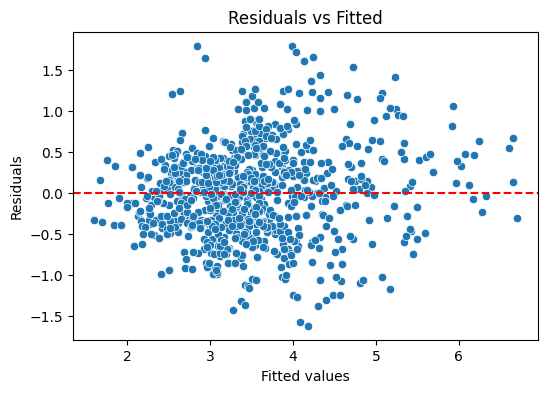

Breusch-Pagan test: LM p=0.113, F p=0.113


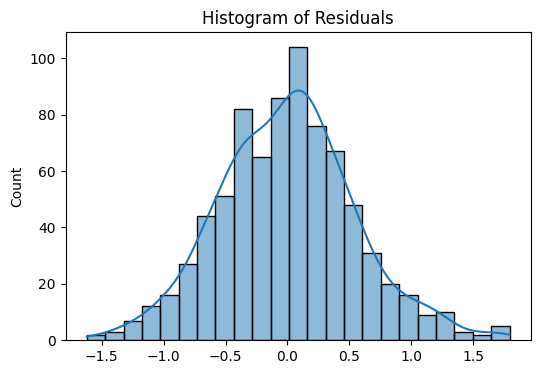

Shapiro-Wilk test for residuals: stat=0.995, p=0.011
Residuals NOT Gaussian (reject H0)
D'Agostino-Pearson test for residuals: stat=8.351, p=0.015


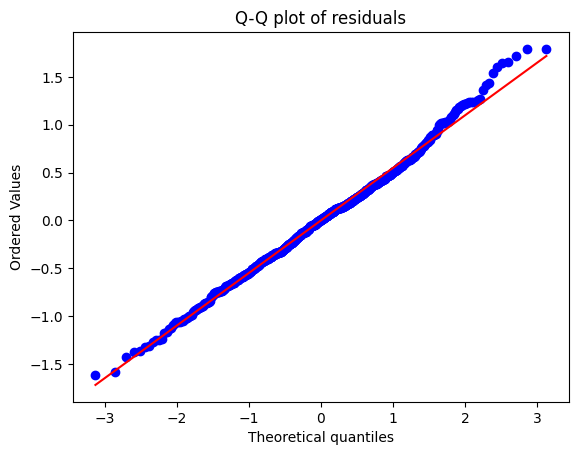

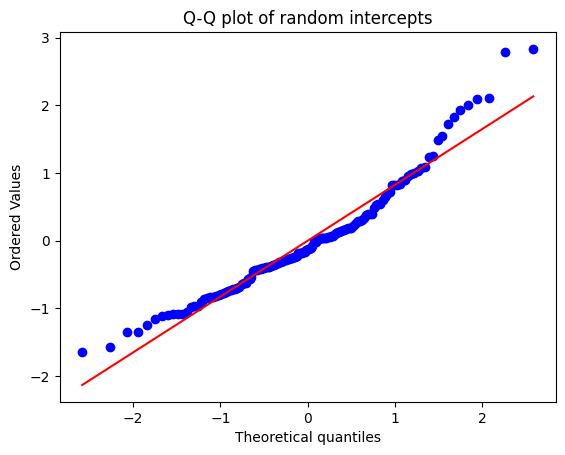

Shapiro-Wilk test for random intercepts: stat=0.949, p=0.000
Random intercepts NOT Gaussian


In [13]:

assumptions(df=df_summary, DVs=[f'headRel_ed_vel_REC'], formula="~ C(pair) * C(trial)")

/var/folders/41/ps8z2q_j48399th9s8y545xr0000gn/T/ipykernel_5150/3063872462.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


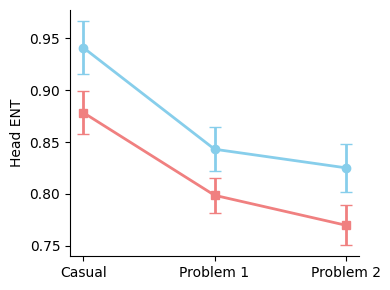

In [ ]:
trial_labels = {
    'trial0': 'Casual',
    'trial1': 'Problem 1',
    'trial2': 'Problem 2'
}

pair_labels = {
    'actual': 'Actual',
    'pseudo': 'Pseudo'
}


for dv in DVs:
    plot_rqa_line_pair(
        df=df,
        trial_col='trial',
        pair_col='pair',
        value_col='headRel_ed_vel_ENTROPY',
        value_label='Head ENT',
        trial_labels=trial_labels,
        pair_labels=pair_labels,
        figsize=(4,3)
    )
